In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA

In [2]:
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations, h for horizon, n is the size of observations used
    # e.g. compute five-step cumulative returns for the first data in S_T need the T_0-(n+4) observation 
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

In [3]:
import yfinance as yf

msft = yf.Ticker("^GDAXI")

hist = msft.history(start = '2022-12-30',end = '2024-02-15')

data_close_price = hist.drop(columns=["Open","High","Low","Volume","Dividends","Stock Splits"])

for i in range(5):
   data_close_price["ret"+str(i+1)] = compute_return(data_close_price["Close"].values, h=i+1)


In [4]:
data_cumret = data_close_price.drop(columns=["Close"]).dropna()

In [5]:
#prepare rolling window samples before 2024
data_train_list = []
due1_data_points = 221
for i in range (7):
    due_data = data_cumret.iloc[:due1_data_points].copy()
    data_train_list.append(due_data)
    due1_data_points +=5
    
print(len(data_train_list))


7


In [6]:
for i in range(len(data_train_list)):
    # Convert the index to datetime format
    data_train_list[i].index = pd.DatetimeIndex(data_train_list[i].index).to_period('D')


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_47819/672054319.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_train_list[i].index = pd.DatetimeIndex(data_train_list[i].index).to_period('D')


In [7]:
due1_data_train = data_train_list[0]

In [8]:
import statsmodels.api as sm

arma_mod_ret4 = sm.tsa.ARIMA(due1_data_train["ret4"], order=(3,0,0))
arma_res_ret4 = arma_mod_ret4.fit()
print(arma_res_ret4.summary())

                               SARIMAX Results                                
Dep. Variable:                   ret4   No. Observations:                  221
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -325.271
Date:                Tue, 02 Apr 2024   AIC                            660.542
Time:                        21:35:54   BIC                            677.533
Sample:                    01-06-2023   HQIC                           667.403
                         - 11-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1627      0.182      0.895      0.371      -0.194       0.519
ar.L1          0.7982      0.070     11.428      0.000       0.661       0.935
ar.L2          0.0991      0.083      1.200      0.2

In [9]:
#AR(2) with ret4~ret4_lag1+ret4_lag3

In [10]:
#1 submission round

In [11]:
due1_ret4 = due1_data_train["ret4"]

due1_lag1_ret4 = due1_ret4[:-1]
due1_lag3_ret4 = due1_ret4[:-3]

due1_ret4_ar2_df = pd.concat([due1_ret4,due1_lag1_ret4,due1_lag3_ret4], axis=1)

due1_ret4_ar2_df.columns = ['ret4', 'ret4_lag1','ret4_lag3']
due1_ret4_ar2_df = due1_ret4_ar2_df.iloc[::-1]

due1_ret4_ar2_df['ret4_lag1']=due1_ret4_ar2_df['ret4_lag1'].shift(-1)
due1_ret4_ar2_df['ret4_lag3']=due1_ret4_ar2_df['ret4_lag3'].shift(-3)
due1_ret4_ar2_df

,ret4,ret4_lag1,ret4_lag3
Date,,,
2023-11-15,2.544323,2.495459,0.648134
2023-11-14,2.495459,1.261494,1.069299
2023-11-13,1.261494,0.648134,0.566290
2023-11-10,0.648134,1.069299,1.525304
2023-11-09,1.069299,0.566290,2.174844
...,...,...,...
2023-01-12,3.022176,3.482497,4.219233
2023-01-11,3.482497,1.939686,3.771530
2023-01-10,1.939686,4.219233,NaN


In [12]:
#Fit quantile regresion model 
import statsmodels.formula.api as smf
tau = [.025, .25, .5, .75, .975]
estimated_values = []

due_date= due1_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due1_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))


due1_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due1_estimated_values_df)

               0.025     0.250    0.500     0.750     0.975
Date                                                       
2023-11-15  0.380594  1.523992  1.92937  2.462078  4.317694


In [13]:
#2 submission round

In [14]:
due2_data_train = data_train_list[1]
due2_ret4 = due2_data_train["ret4"]

due2_lag1_ret4 = due2_ret4[:-1]
due2_lag3_ret4 = due2_ret4[:-3]

due2_ret4_ar2_df = pd.concat([due2_ret4,due2_lag1_ret4,due2_lag3_ret4], axis=1)

due2_ret4_ar2_df.columns = ['ret4', 'ret4_lag1','ret4_lag3']
due2_ret4_ar2_df = due2_ret4_ar2_df.iloc[::-1]

due2_ret4_ar2_df['ret4_lag1']=due2_ret4_ar2_df['ret4_lag1'].shift(-1)
due2_ret4_ar2_df['ret4_lag3']=due2_ret4_ar2_df['ret4_lag3'].shift(-3)

#Fit quantile regresion model 
estimated_values = []

due_date= due2_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due2_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))


due2_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due2_estimated_values_df)



               0.025     0.250     0.500     0.750     0.975
Date                                                        
2023-11-22 -2.333383 -0.608655  0.233025  0.763073  1.305136


In [15]:
#3 submission round

In [16]:
due3_data_train = data_train_list[2]
due3_ret4 = due3_data_train["ret4"]

due3_lag1_ret4 = due3_ret4[:-1]
due3_lag3_ret4 = due3_ret4[:-3]

due3_ret4_ar2_df = pd.concat([due3_ret4, due3_lag1_ret4, due3_lag3_ret4], axis=1)

due3_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due3_ret4_ar2_df = due3_ret4_ar2_df.iloc[::-1]

due3_ret4_ar2_df['ret4_lag1'] = due3_ret4_ar2_df['ret4_lag1'].shift(-1)
due3_ret4_ar2_df['ret4_lag3'] = due3_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due3_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due3_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due3_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due3_estimated_values_df)


               0.025    0.250     0.500     0.750     0.975
Date                                                       
2023-11-29 -2.311885 -0.52722  0.173053  0.684462  1.959701


In [17]:
#4 submission round

In [18]:
due4_data_train = data_train_list[3]
due4_ret4 = due4_data_train["ret4"]

due4_lag1_ret4 = due4_ret4[:-1]
due4_lag3_ret4 = due4_ret4[:-3]

due4_ret4_ar2_df = pd.concat([due4_ret4, due4_lag1_ret4, due4_lag3_ret4], axis=1)

due4_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due4_ret4_ar2_df = due4_ret4_ar2_df.iloc[::-1]

due4_ret4_ar2_df['ret4_lag1'] = due4_ret4_ar2_df['ret4_lag1'].shift(-1)
due4_ret4_ar2_df['ret4_lag3'] = due4_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due4_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due4_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due4_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due4_estimated_values_df)


               0.025     0.250     0.500    0.750     0.975
Date                                                       
2023-12-06 -0.535539  0.825044  1.473203  2.01068  3.080053


In [19]:
#5 submission round

In [20]:
due5_data_train = data_train_list[4]
due5_ret4 = due5_data_train["ret4"]

due5_lag1_ret4 = due5_ret4[:-1]
due5_lag3_ret4 = due5_ret4[:-3]

due5_ret4_ar2_df = pd.concat([due5_ret4, due5_lag1_ret4, due5_lag3_ret4], axis=1)

due5_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due5_ret4_ar2_df = due5_ret4_ar2_df.iloc[::-1]

due5_ret4_ar2_df['ret4_lag1'] = due5_ret4_ar2_df['ret4_lag1'].shift(-1)
due5_ret4_ar2_df['ret4_lag3'] = due5_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due5_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due5_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due5_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due5_estimated_values_df)


               0.025     0.250     0.500    0.750     0.975
Date                                                       
2023-12-13 -2.037841 -0.186695  0.410033  0.96848  1.772039


In [21]:
#6 submission round

In [22]:
due6_data_train = data_train_list[5]
due6_ret4 = due6_data_train["ret4"]

due6_lag1_ret4 = due6_ret4[:-1]
due6_lag3_ret4 = due6_ret4[:-3]

due6_ret4_ar2_df = pd.concat([due6_ret4, due6_lag1_ret4, due6_lag3_ret4], axis=1)

due6_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due6_ret4_ar2_df = due6_ret4_ar2_df.iloc[::-1]

due6_ret4_ar2_df['ret4_lag1'] = due6_ret4_ar2_df['ret4_lag1'].shift(-1)
due6_ret4_ar2_df['ret4_lag3'] = due6_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due6_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due6_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due6_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due6_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2023-12-20 -2.326518 -0.516555  0.093064  0.589845  2.166448


In [23]:
#7 submission round 2024

In [24]:
due7_data_train = data_cumret[:258]
due7_data_train.index = pd.DatetimeIndex(due7_data_train.index).to_period('D')


due7_ret4 = due7_data_train["ret4"]

due7_lag1_ret4 = due7_ret4[:-1]
due7_lag3_ret4 = due7_ret4[:-3]

due7_ret4_ar2_df = pd.concat([due7_ret4, due7_lag1_ret4, due7_lag3_ret4], axis=1)

due7_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due7_ret4_ar2_df = due7_ret4_ar2_df.iloc[::-1]

due7_ret4_ar2_df['ret4_lag1'] = due7_ret4_ar2_df['ret4_lag1'].shift(-1)
due7_ret4_ar2_df['ret4_lag3'] = due7_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due7_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due7_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due7_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due7_estimated_values_df)


               0.025     0.250    0.500     0.750     0.975
Date                                                       
2024-01-10 -0.940604  0.533085  1.04525  1.532114  3.401411


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_47819/1543230252.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due7_data_train.index = pd.DatetimeIndex(due7_data_train.index).to_period('D')


In [25]:
#8 submission round

In [26]:
due8_data_train = data_cumret[:258+5]
due8_data_train.index = pd.DatetimeIndex(due8_data_train.index).to_period('D')


due8_ret4 = due8_data_train["ret4"]

due8_lag1_ret4 = due8_ret4[:-1]
due8_lag3_ret4 = due8_ret4[:-3]

due8_ret4_ar2_df = pd.concat([due8_ret4, due8_lag1_ret4, due8_lag3_ret4], axis=1)

due8_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due8_ret4_ar2_df = due8_ret4_ar2_df.iloc[::-1]

due8_ret4_ar2_df['ret4_lag1'] = due8_ret4_ar2_df['ret4_lag1'].shift(-1)
due8_ret4_ar2_df['ret4_lag3'] = due8_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due8_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due8_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due8_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due8_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-01-17 -3.047402 -1.062547 -0.431308  0.071821  1.399693


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_47819/2550490153.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due8_data_train.index = pd.DatetimeIndex(due8_data_train.index).to_period('D')


In [27]:
#9 submission round

In [28]:
due9_data_train = data_cumret[:258+10]
due9_data_train.index = pd.DatetimeIndex(due9_data_train.index).to_period('D')


due9_ret4 = due9_data_train["ret4"]

due9_lag1_ret4 = due9_ret4[:-1]
due9_lag3_ret4 = due9_ret4[:-3]

due9_ret4_ar2_df = pd.concat([due9_ret4, due9_lag1_ret4, due9_lag3_ret4], axis=1)

due9_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due9_ret4_ar2_df = due9_ret4_ar2_df.iloc[::-1]

due9_ret4_ar2_df['ret4_lag1'] = due9_ret4_ar2_df['ret4_lag1'].shift(-1)
due9_ret4_ar2_df['ret4_lag3'] = due9_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due9_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due9_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due9_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due9_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-01-24 -0.779346  0.669582  1.156007  1.649287  3.391941


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_47819/1287869039.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due9_data_train.index = pd.DatetimeIndex(due9_data_train.index).to_period('D')


In [29]:
#10 submission round

In [30]:
due10_data_train = data_cumret[:258+15]
due10_data_train.index = pd.DatetimeIndex(due10_data_train.index).to_period('D')

due10_ret4 = due10_data_train["ret4"]

due10_lag1_ret4 = due10_ret4[:-1]
due10_lag3_ret4 = due10_ret4[:-3]

due10_ret4_ar2_df = pd.concat([due10_ret4, due10_lag1_ret4, due10_lag3_ret4], axis=1)

due10_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due10_ret4_ar2_df = due10_ret4_ar2_df.iloc[::-1]

due10_ret4_ar2_df['ret4_lag1'] = due10_ret4_ar2_df['ret4_lag1'].shift(-1)
due10_ret4_ar2_df['ret4_lag3'] = due10_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due10_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due10_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due10_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due10_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-01-31 -2.183131 -0.335567  0.228216  0.696379  1.662455


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_47819/2923786649.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due10_data_train.index = pd.DatetimeIndex(due10_data_train.index).to_period('D')


In [31]:
#11 submission round

In [32]:
due11_data_train = data_cumret[:258+20]
due11_data_train.index = pd.DatetimeIndex(due11_data_train.index).to_period('D')

due11_ret4 = due11_data_train["ret4"]

due11_lag1_ret4 = due11_ret4[:-1]
due11_lag3_ret4 = due11_ret4[:-3]

due11_ret4_ar2_df = pd.concat([due11_ret4, due11_lag1_ret4, due11_lag3_ret4], axis=1)

due11_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due11_ret4_ar2_df = due11_ret4_ar2_df.iloc[::-1]

due11_ret4_ar2_df['ret4_lag1'] = due11_ret4_ar2_df['ret4_lag1'].shift(-1)
due11_ret4_ar2_df['ret4_lag3'] = due11_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due11_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due11_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due11_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due11_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-02-07 -1.338152  0.271279  0.792116  1.264886  2.851855


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_47819/4275908945.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due11_data_train.index = pd.DatetimeIndex(due11_data_train.index).to_period('D')


In [33]:
#12 submission round

In [34]:
due12_data_train = data_cumret[:258+25]
due12_data_train.index = pd.DatetimeIndex(due12_data_train.index).to_period('D')

due12_ret4 = due12_data_train["ret4"]

due12_lag1_ret4 = due12_ret4[:-1]
due12_lag3_ret4 = due12_ret4[:-3]

due12_ret4_ar2_df = pd.concat([due12_ret4, due12_lag1_ret4, due12_lag3_ret4], axis=1)

due12_ret4_ar2_df.columns = ['ret4', 'ret4_lag1', 'ret4_lag3']
due12_ret4_ar2_df = due12_ret4_ar2_df.iloc[::-1]

due12_ret4_ar2_df['ret4_lag1'] = due12_ret4_ar2_df['ret4_lag1'].shift(-1)
due12_ret4_ar2_df['ret4_lag3'] = due12_ret4_ar2_df['ret4_lag3'].shift(-3)

# Fit quantile regression model 
estimated_values = []

due_date = due12_ret4_ar2_df.head(1)
for q in tau:
    formula = f'ret4 ~ ret4_lag1 + ret4_lag3'  
    model = smf.quantreg(formula, due12_ret4_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due12_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 4-step ahead R on T_0+4
print(due12_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-02-14 -2.370169 -0.648875 -0.091915  0.401924  1.743755


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_47819/3164148225.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due12_data_train.index = pd.DatetimeIndex(due12_data_train.index).to_period('D')


In [35]:
FC_results_list = [due1_estimated_values_df, due2_estimated_values_df, due3_estimated_values_df, due4_estimated_values_df,
                  due5_estimated_values_df, due6_estimated_values_df, due7_estimated_values_df, 
                  due8_estimated_values_df, due9_estimated_values_df,
                  due10_estimated_values_df, due11_estimated_values_df, due12_estimated_values_df]
FC_results_df = pd.concat(FC_results_list, axis=0)

In [36]:
FC_results_df

,0.025,0.250,0.500,0.750,0.975
Date,,,,,
2023-11-15,0.380594,1.523992,1.929370,2.462078,4.317694
2023-11-22,-2.333383,-0.608655,0.233025,0.763073,1.305136
2023-11-29,-2.311885,-0.527220,0.173053,0.684462,1.959701
2023-12-06,-0.535539,0.825044,1.473203,2.010680,3.080053
2023-12-13,-2.037841,-0.186695,0.410033,0.968480,1.772039
2023-12-20,-2.326518,-0.516555,0.093064,0.589845,2.166448
2024-01-10,-0.940604,0.533085,1.045250,1.532114,3.401411
2024-01-17,-3.047402,-1.062547,-0.431308,0.071821,1.399693
2024-01-24,-0.779346,0.669582,1.156007,1.649287,3.391941


In [40]:
#forcasting evaluation
realized_data = msft.history(start='2022-12-30', end='2024-02-26')
realized_data["ret4"] = compute_return(realized_data["Close"].values, h=4)

realized_data = realized_data.drop(columns=["Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"])
realized_data

,ret4
Date,
2022-12-30 00:00:00+01:00,NaN
2023-01-02 00:00:00+01:00,NaN
2023-01-03 00:00:00+01:00,NaN
2023-01-04 00:00:00+01:00,NaN
2023-01-05 00:00:00+01:00,3.616202
...,...
2024-02-19 00:00:00+01:00,1.244705
2024-02-20 00:00:00+01:00,0.722938
2024-02-21 00:00:00+01:00,0.418148


In [41]:
realized_data.loc['2023-12-26 00:00:00+01:00'] = 0.00
realized_data.index = pd.to_datetime(realized_data.index)
realized_data = realized_data.sort_index()

In [42]:
dates =  ['2023-11-15', '2023-11-22', '2023-11-29', '2023-12-06', '2023-12-13', '2023-12-20',
         '2024-01-10', '2024-01-17', '2024-01-24', '2024-01-31', '2024-02-07', '2024-02-14']

# Increment each date by 6 day, Tue.
dates_4stephead = [(pd.to_datetime(date) + pd.DateOffset(days=6)).strftime('%Y-%m-%d') for date in dates]

# Use the incremented dates to select data from relized_data
realized_T04 = realized_data.loc[dates_4stephead]

In [43]:
def quantile_score(q_hat, y, tau):
    scores = []
    for i in range(len(tau)):
        if q_hat[i] > y:
            score = 2 * (1 - tau[i]) * (q_hat[i] - y)
        elif y >= q_hat[i]:
            score = 2 * tau[i] * (y - q_hat[i])
        else:
            score = 0
        scores.append(score)
    return scores

ret_4_scores = []


# Iterate over each submission day (row) in FC_results

for i in range(FC_results_df.shape[0]):
    q_hat = FC_results_df.iloc[i].values
    y = realized_T04.iloc[i].values
    scores = quantile_score(q_hat, y, tau)
    ret_4_scores.append(scores)
    
ret_4_scores

[[array([0.02911176]),
  array([0.84174344]),
  array([0.96654013]),
  array([0.7496241]),
  array([0.16774322])],
 [array([0.12757652]),
  array([0.4134014]),
  array([0.01487752]),
  array([0.27246261]),
  array([0.05434941])],
 [array([0.22772867]),
  array([1.38495377]),
  array([2.06963516]),
  array([2.33733844]),
  array([0.551824])],
 [array([0.06722804]),
  array([0.02403407]),
  array([0.66418112]),
  array([0.60082922]),
  array([0.11355157])],
 [array([0.0954342]),
  array([0.02876882]),
  array([0.53919017]),
  array([0.54881888]),
  array([0.09505984])],
 [array([0.11632589]),
  array([0.25827755]),
  array([0.09306366]),
  array([0.29492256]),
  array([0.10832238])],
 [array([0.01151422]),
  array([1.86510664]),
  array([1.7555694]),
  array([1.12121659]),
  array([0.2055865])],
 [array([0.21147775]),
  array([1.12234977]),
  array([1.61346045]),
  array([1.66549812]),
  array([0.01087702])],
 [array([0.06330708]),
  array([0.27417898]),
  array([0.66921044]),
  array([0

In [44]:
columns = ['due1', 'due2', 'due3', 'due4', 'due5', 'due6', 'due7', 'due8', 'due9', 'due10', 'due11', 'due12']
ret_4_scores_df = pd.DataFrame(ret_4_scores).T
ret_4_scores_df.columns = columns
ret_4_scores_df.index = tau

In [45]:
ret_4_scores_df

,due1,due2,due3,due4,due5,due6,due7,due8,due9,due10,due11,due12
0.025,[0.02911175750850922],[0.12757651897537867],[0.2277286696363266],[0.06722803876279375],[0.0954342000656771],[0.11632589202364348],[0.011514224313479683],[0.2114777501703002],[0.0633070844089009],[0.14730993208682838],[0.054739698744148184],[0.1546553519465156]
0.250,[0.8417434449506119],[0.4134014046157684],[1.3849537704682415],[0.02403406538777031],[0.028768819158813907],[0.25827755433552646],[1.8651066398349776],[1.1223497671219138],[0.2741789763852557],[0.5493173581661113],[0.7719551877293077],[0.685906305293637]
0.500,[0.966540127895581],[0.014877521301974506],[2.0696351629202963],[0.6641811150582213],[0.5391901673100358],[0.09306365644557094],[1.7555694037323193],[1.613460452047081],[0.6692104403251982],[0.5348516880071295],[1.035474346814214],[0.8148526425820976]
0.750,[0.7496241013140448],[0.2724626052385952],[2.3373384445557366],[0.6008292168574298],[0.5488188770000414],[0.2949225646130601],[1.1212165871468551],[1.665498120546185],[0.581245382452714],[0.10003212206697265],[0.7541217803621987],[0.4815209721317275]
0.975,[0.16774322276903322],[0.054349410427036754],[0.5518240026230391],[0.11355157087635939],[0.09505984120316266],[0.10832238269463051],[0.20558650223944644],[0.010877022173008254],[0.14525726781895462],[0.04496937308881452],[0.15476065725197527],[0.05104086247080292]


In [46]:
ret_4_scores_df=ret_4_scores_df.astype(float)

In [47]:
ret_4_scores_df

,due1,due2,due3,due4,due5,due6,due7,due8,due9,due10,due11,due12
0.025,0.029112,0.127577,0.227729,0.067228,0.095434,0.116326,0.011514,0.211478,0.063307,0.147310,0.054740,0.154655
0.250,0.841743,0.413401,1.384954,0.024034,0.028769,0.258278,1.865107,1.122350,0.274179,0.549317,0.771955,0.685906
0.500,0.966540,0.014878,2.069635,0.664181,0.539190,0.093064,1.755569,1.613460,0.669210,0.534852,1.035474,0.814853
0.750,0.749624,0.272463,2.337338,0.600829,0.548819,0.294923,1.121217,1.665498,0.581245,0.100032,0.754122,0.481521
0.975,0.167743,0.054349,0.551824,0.113552,0.095060,0.108322,0.205587,0.010877,0.145257,0.044969,0.154761,0.051041


<Axes: >

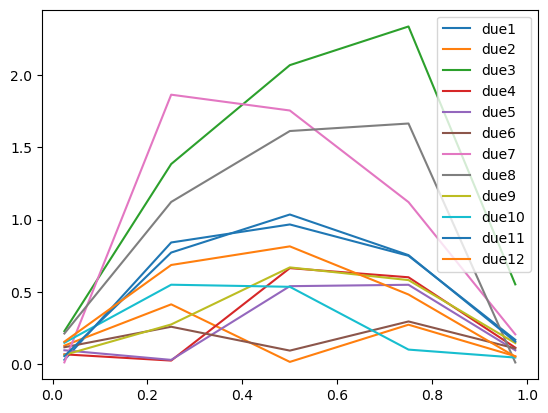

In [48]:
ret_4_scores_df.plot()